We're going to start off by importing our packages and reading in our data from `../data/AviationData.csv` and `../data/USState_Codes.csv`. We will eventually save our cleaned data as a separate `AviationData_cleaned.csv`, which we will then use for our analysis.

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [158]:
# Import data
df = pd.read_csv('../data/AviationData.csv', encoding='latin-1')
state_codes = pd.read_csv('../data/USState_Codes.csv')

c:\Users\nateh\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (6,7,28) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [159]:
df.head()

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.9222,-81.8781,NaN,NaN,...,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980


In [160]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88889 entries, 0 to 88888
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                88889 non-null  object 
 1   Investigation.Type      88889 non-null  object 
 2   Accident.Number         88889 non-null  object 
 3   Event.Date              88889 non-null  object 
 4   Location                88837 non-null  object 
 5   Country                 88663 non-null  object 
 6   Latitude                34382 non-null  object 
 7   Longitude               34373 non-null  object 
 8   Airport.Code            50249 non-null  object 
 9   Airport.Name            52790 non-null  object 
 10  Injury.Severity         87889 non-null  object 
 11  Aircraft.damage         85695 non-null  object 
 12  Aircraft.Category       32287 non-null  object 
 13  Registration.Number     87572 non-null  object 
 14  Make                    88826 non-null

### Initial Data Cleaning

In [161]:
# Change the date column to a datetime object
df['Event.Date'] = pd.to_datetime(df['Event.Date'])
# Creating a column for the year and insert next to Event.Date
df['Year'] = df['Event.Date'].dt.year
df.insert(4, 'Year', df.pop('Year'))

# Make everything in the df lowercase so we can get more accurate counts
df = df.applymap(lambda x: x.lower() if type(x) == str else x)
# Renaming columns in titlecase (aesthetic purposes only)
df = df.rename(columns={'Event.Id':'Event.ID','Aircraft.damage':'Aircraft.Damage','Purpose.of.flight':'Purpose.of.Flight','Air.carrier':'Air.Carrier','Broad.phase.of.flight':'Broad.Phase.of.Flight'})

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88889 entries, 0 to 88888
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Event.ID                88889 non-null  object        
 1   Investigation.Type      88889 non-null  object        
 2   Accident.Number         88889 non-null  object        
 3   Event.Date              88889 non-null  datetime64[ns]
 4   Year                    88889 non-null  int64         
 5   Location                88837 non-null  object        
 6   Country                 88663 non-null  object        
 7   Latitude                34382 non-null  object        
 8   Longitude               34373 non-null  object        
 9   Airport.Code            50249 non-null  object        
 10  Airport.Name            52790 non-null  object        
 11  Injury.Severity         87889 non-null  object        
 12  Aircraft.Damage         85695 non-null  object

### Geographic Filtering

In [162]:
# Filter to include only US events and remove 'Country' column
df = df[df['Country'] == 'united states']
df = df.drop(columns=['Country'])

In [163]:
# Create new column 'State.Code' pulling info from 'Location'
df['State.Code'] = df['Location'].str.split(',').str[-1].str.strip().str.upper()
df = df.dropna(subset=['State.Code'])

# Create new column 'State.Names' merging info from state_codes df
df = pd.merge(df, state_codes, how='left', left_on='State.Code', right_on='Abbreviation')
df = df.drop(['Abbreviation'], 1)
df = df.rename(columns={'US_State':'State.Name'})
df = df.dropna(subset=['State.Name'])

# Move both columns next to 'Location'
df.insert(6, 'State.Code', df.pop('State.Code'))
df.insert(7, 'State.Name', df.pop('State.Name'))

In [164]:
# Map states to regions based off data from http://nationalgeographic.org/maps/united-states-regions/
# DC is categorized as a state
# Atlantic and Pacific categorized as 'Ocean'
# Guam, PR, VI, Gulf of Mexico categorized as 'Other Territory'

states_to_regions = {
    'Washington': 'West', 'Oregon': 'West', 'California': 'West', 'Nevada': 'West',
    'Idaho': 'West', 'Montana': 'West', 'Wyoming': 'West', 'Utah': 'West',
    'Colorado': 'West', 'Alaska': 'West', 'Hawaii': 'West', 'Maine': 'Northeast',
    'Vermont': 'Northeast', 'New York': 'Northeast', 'New Hampshire': 'Northeast',
    'Massachusetts': 'Northeast', 'Rhode Island': 'Northeast', 'Connecticut': 'Northeast',
    'New Jersey': 'Northeast', 'Pennsylvania': 'Northeast', 'North Dakota': 'Midwest',
    'South Dakota': 'Midwest', 'Nebraska': 'Midwest', 'Kansas': 'Midwest',
    'Minnesota': 'Midwest', 'Iowa': 'Midwest', 'Missouri': 'Midwest', 'Wisconsin': 'Midwest',
    'Illinois': 'Midwest', 'Michigan': 'Midwest', 'Indiana': 'Midwest', 'Ohio': 'Midwest',
    'West Virginia': 'South', 'Maryland': 'South', 'Virginia': 'South', 'Kentucky': 'South', 
    'Tennessee': 'South', 'North Carolina': 'South', 'Mississippi': 'South', 'Arkansas': 'South', 
    'Louisiana': 'South', 'Alabama': 'South', 'Georgia': 'South', 'South Carolina': 'South', 
    'Florida': 'South', 'Delaware': 'South', 'Arizona': 'Southwest', 'New Mexico': 'Southwest', 
    'Oklahoma': 'Southwest', 'Texas': 'Southwest', 'Washington_DC': 'South', 
    'Guam': 'Other Territory', 'Puerto Rico': 'Other Territory', 'Virgin Islands': 'Other Territory',
     'Gulf of mexico': 'Other Territory', 'Atlantic ocean': 'Ocean', 'Pacific ocean': 'Ocean' }

df['Region'] = df['State.Name'].map(states_to_regions)
df.insert(8, 'Region', df.pop('Region'))
df['Region'].value_counts()

West               27936
South              19582
Midwest            15469
Southwest          11345
Northeast           7618
Other Territory      172
Ocean                 31
Name: Region, dtype: int64

### Aircraft Type

Since we're trying to find the safest option for a business looking to get into aviation, we're going to go ahead and exclude amateur-built planes. 

We're also going to filter out any non-airplanes (e.g. helicopters, gliders, and so on), but pay attention to what that does to our `Year` data -- we get some pretty funky results, for which we couldn't find explanations in regulatory changes or similar. As a result, we try not to do too much with the year-on-year data in our analysis.

In [165]:
# Filter out 'Amateur.Built' aircraft and remove column
df = df[df['Amateur.Built'] == 'no']
df = df.drop(columns=['Amateur.Built'])

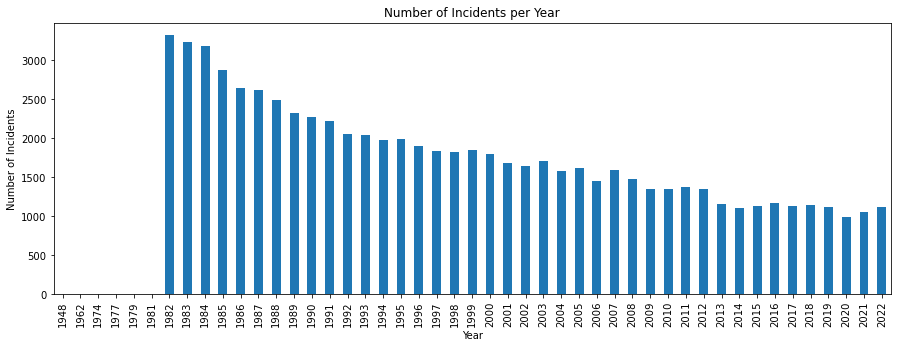

In [166]:
# One interesting thing to note here is the difference in the number of events per year
# Here is the original data *before* we filter out non-airplane events

df['Year'].value_counts().sort_index().plot(kind='bar', figsize=(15, 5))
plt.title('Number of Incidents per Year')
plt.xlabel('Year')
plt.ylabel('Number of Incidents');

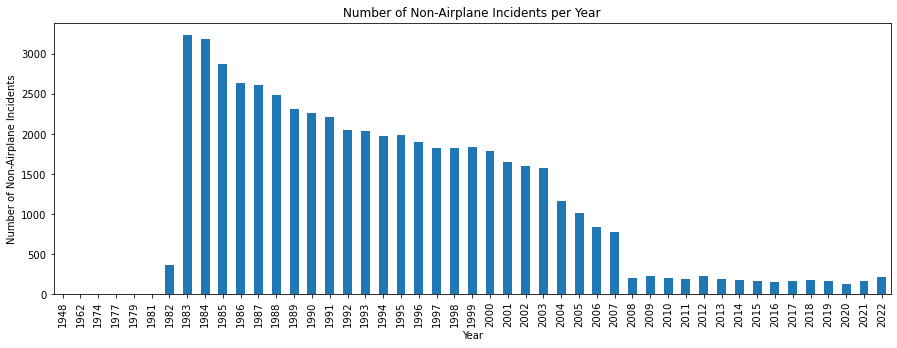

In [167]:
# We can see that the airplane-related incidents and the non-airplane-related incidents are mirror images of each other

df_notplanes = df[df['Aircraft.Category'] != 'airplane']
df_notplanes['Year'].value_counts().sort_index().plot(kind='bar', figsize=(15, 5))
plt.title('Number of Non-Airplane Incidents per Year')
plt.xlabel('Year')
plt.ylabel('Number of Non-Airplane Incidents');

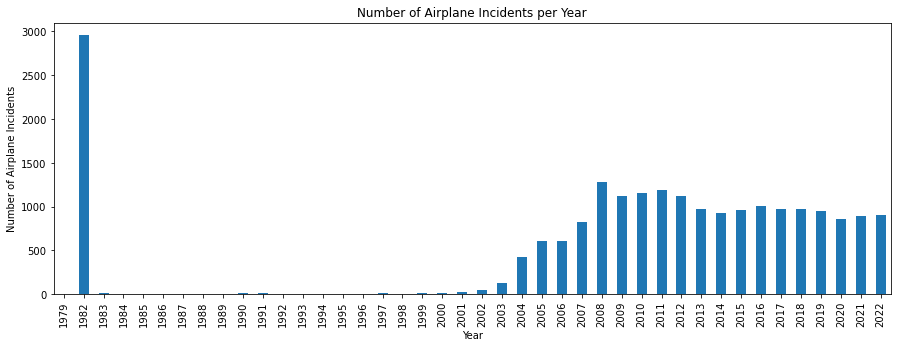

In [168]:
# Filter to include only 'airplane' events and remove 'Aircraft.Category' column
df = df[df['Aircraft.Category'] == 'airplane']
df = df.drop(columns=['Aircraft.Category'])

# Regraph after filtering
df['Year'].value_counts().sort_index().plot(kind='bar', figsize=(15, 5))
plt.title('Number of Airplane Incidents per Year')
plt.xlabel('Year')
plt.ylabel('Number of Airplane Incidents');

### Time Frame

Given more time, fully understanding and dealing with this yearly data would be helpful for a detailed analysis. One could start by subsetting the data by `Year >= 2007`; for the present analysis, we decided to keep all of the data.

### FAR Codes & Purpose of Flight

In [169]:
df['FAR.Description'].value_counts()

091                               13310
part 91: general aviation          5036
137                                 739
135                                 519
121                                 517
part 137: agricultural              360
part 135: air taxi & commuter       229
pubu                                124
part 121: air carrier               109
129                                  43
part 129: foreign                    14
091k                                 14
unknown                              10
public use                            9
nusc                                  7
unk                                   6
nusn                                  4
part 125: 20+ pax,6000+ lbs           4
125                                   4
armf                                  2
part 133: rotorcraft ext. load        2
part 91f: special flt ops.            1
part 91 subpart k: fractional         1
public aircraft                       1
Name: FAR.Description, dtype: int64

In [170]:
# Cleaning up the FAR.Description column using .replace() 
# See here for more info on FAR: 
# https://pilotinstitute.com/part-91-vs-121-vs-135/

# Part 91 - general aviation
df['FAR.Description'] = df['FAR.Description'].replace(['091','part 91: general aviation','091k','part91f','part 91 subpart f','part 91f: special flt ops.','part 91 subpart k: fractional'], 'part 91')

# Part 121 - scheduled commercial (airlines, cargo)
df['FAR.Description'] = df['FAR.Description'].replace(['121','part 121: air carrier'], 'part 121')

# Part 135 - non-scheduled commercial (private jet, air taxi)
df['FAR.Description'] = df['FAR.Description'].replace(['135','part 135: air taxi & commuter'], 'part 135')

# Part 137 - agricultural 
df['FAR.Description'] = df['FAR.Description'].replace(['137','part 137: agricultural'], 'part 137')

# Part 129 - foreign air carriers
df['FAR.Description'] = df['FAR.Description'].replace(['129','part 129: foreign'], 'part 129')

# NUSC - non-US commercial
# NUSN - non-US non-commercial
df['FAR.Description'] = df['FAR.Description'].replace(['nusc','nusn'], 'non-US')

# Part 125 - 20+ passengers
df['FAR.Description'] = df['FAR.Description'].replace(['125','part 125: 20+ pax,6000+ lbs'], 'part 125')

# Part 133 - helicopters
df['FAR.Description'] = df['FAR.Description'].replace(['133','part 133: rotorcraft external load','part 133: rotorcraft ext. load'], 'part 133')

# Public
df['FAR.Description'] = df['FAR.Description'].replace(['pubu','public use','public aircraft'], 'public')

# Unknown
df['FAR.Description'] = df['FAR.Description'].replace(['unk'], 'unknown')

# Armed Forces
df['FAR.Description'] = df['FAR.Description'].replace(['armf'], 'armed forces')

df['FAR.Description'].value_counts()

part 91         18362
part 137         1099
part 135          748
part 121          626
public            134
part 129           57
unknown            16
non-US             11
part 125            8
armed forces        2
part 133            2
Name: FAR.Description, dtype: int64

In [171]:
df['Purpose.of.Flight'].value_counts()

personal                     13026
instructional                 3054
aerial application            1014
business                       722
unknown                        550
positioning                    336
skydiving                      158
aerial observation             153
ferry                          148
other work use                 141
executive/corporate            137
flight test                    114
banner tow                      89
public aircraft - federal       48
air race show                   39
public aircraft                 38
glider tow                      34
public aircraft - state         24
firefighting                    14
public aircraft - local         12
asho                             5
air race/show                    4
air drop                         3
pubs                             3
Name: Purpose.of.Flight, dtype: int64

In [172]:
# New column 'Purpose.Binned' to group 'Purpose.of.Flight' into more general categories

# New category 'public - govt' to include 'public aircraft - federal', 'public aircraft - state', 'public aircraft - local', 'public aircraft - u.s. govt.', 'pubs', 'firefighting' 
df['Purpose.Binned'] = df['Purpose.of.Flight'].replace(['public aircraft - federal', 'public aircraft - state', 'pubs', 'public aircraft - local', 'publ', 'public aircraft - u.s. govt.','firefighting'], 'public - govt')

# New category 'public transport' to include 'public aircraft',
df['Purpose.Binned'] = df['Purpose.Binned'].replace(['public aircraft'], 'public transport')

# New category 'business' to include 'business', 'other work use', 'banner tow', 'air drop'
df['Purpose.Binned'] = df['Purpose.Binned'].replace(['business', 'other work use', 'banner tow', 'air drop'], 'business')

# New category 'recreational' to include 'skydiving', 'glider tow'
df['Purpose.Binned'] = df['Purpose.Binned'].replace(['skydiving', 'glider tow'], 'recreational')

# New category 'private transport' to include 'executive/corporate', 'ferry'
df['Purpose.Binned'] = df['Purpose.Binned'].replace(['executive/corporate', 'ferry'], 'private transport')

# New category 'air show' to include 'air race show', 'air race/show', 'asho'
df['Purpose.Binned'] = df['Purpose.Binned'].replace(['air race show', 'air race/show', 'asho'], 'air show')

df.insert(23, 'Purpose.Binned', df.pop('Purpose.Binned'))
df['Purpose.Binned'].value_counts()

personal              13026
instructional          3054
aerial application     1014
business                955
unknown                 550
positioning             336
private transport       285
recreational            192
aerial observation      153
flight test             114
public - govt           101
air show                 48
public transport         38
Name: Purpose.Binned, dtype: int64

### Filtering the 'Make' series

The make of the aircraft is going to be important to our analysis since we want to find the safest make (or the safest make given the chosen purpose of our aircraft). There's a lot of noise in the data, however, so we first try to group the most popular makes according to name. In our analysis, we'll then take the top 25 and top 10 most popular makes to draw our conclusions.


In [173]:
# Checking out the raw 'Make' values
df['Make'].value_counts()

cessna                    7679
piper                     4311
beech                     1520
boeing                     446
mooney                     391
                          ... 
rolladen-schneider           1
columbia aircraft mfg.       1
hughes aero corp             1
carlo robert                 1
europro cz                   1
Name: Make, Length: 1015, dtype: int64

In [174]:
# Make a list of all the entries that have "cessna" in them and return their strings in a list
cessna_list = df[df['Make'].str.contains('cessna')]['Make'].unique().tolist()

#Do the same with the other big makes
grumman_list = df[df['Make'].str.contains('grumman')]['Make'].unique().tolist()
dehavilland_list = df[df['Make'].str.contains('havilland')]['Make'].unique().tolist()
cirrus_list = df[df['Make'].str.contains('cirrus')]['Make'].unique().tolist()
piper_list = df[df['Make'].str.contains('piper')]['Make'].unique().tolist()
boeing_list = df[df['Make'].str.contains('boeing')]['Make'].unique().tolist()
mooney_list = df[df['Make'].str.contains('mooney')]['Make'].unique().tolist()
airtractor_list = df[df['Make'].str.contains('air tractor')]['Make'].unique().tolist()

print(cessna_list)
print(grumman_list)
print(dehavilland_list)
print(cirrus_list)
print(piper_list)
print(boeing_list)
print(mooney_list)
print(airtractor_list)

['cessna', 'cessna aircraft co', 'cessna/air repair inc', 'cessna/weaver', 'cessna ector', 'cessna aircraft', 'cessna aircraft co.']
['grumman', 'grumman american', 'grumman-schweizer', 'grumman american avn. corp.', 'grumman american aviation', 'grumman acft eng', 'grumman acft eng cor-schweizer', 'grumman aircraft eng corp', 'grumman american aviation corp', 'grumman aircraft', 'grumman schweizer', 'grumman acft eng cor', 'grumman aircraft cor-schweizer', 'grumman american avn. corp']
['de havilland', 'dehavilland', 'dehavilland canada']
['cirrus design corp.', 'cirrus', 'cirrus design', 'cirrus design corp', 'cirrus design corporation']
['piper', 'piper-aerostar', 'piper aircraft', 'piper/cub crafters', 'piper cub crafters', 'piper aerostar', 'new piper aircraft inc', 'piper aircraft inc', 'jetprop dlx piper', "piper/wally's flyers inc", 'piper aircraft, inc.', 'new piper', 'piper / laudeman', 'piper-harris', 'piper aircraft corporation']
['boeing', 'boeing stearman', 'boeing of can

In [175]:
df['Make'] = df['Make'].replace(cessna_list, 'cessna')
df['Make'] = df['Make'].replace(grumman_list, 'grumman')
df['Make'] = df['Make'].replace(dehavilland_list, 'dehavilland')
df['Make'] = df['Make'].replace(cirrus_list, 'cirrus')
df['Make'] = df['Make'].replace(piper_list, 'piper')
df['Make'] = df['Make'].replace(mooney_list, 'mooney')
df['Make'] = df['Make'].replace(airtractor_list, 'airtractor')

# And we can now see the totals, with slightly different numbers than before.
df['Make'].value_counts()

cessna                7712
piper                 4357
beech                 1520
boeing                 446
mooney                 437
                      ... 
breezer aircraft         1
grum amer                1
fields mike              1
rolladen-schneider       1
europro cz               1
Name: Make, Length: 968, dtype: int64

In [176]:
# Making a new df that only accepts the top 25 makes:
top_makes = df['Make'].value_counts().head(25).index.tolist()
top_makes_df = df[df['Make'].isin(top_makes)].copy()
top_makes_df['Make'].value_counts()

cessna                       7712
piper                        4357
beech                        1520
boeing                        446
mooney                        437
airtractor                    414
grumman                       409
cirrus                        328
bellanca                      279
aeronca                       226
maule                         225
champion                      164
dehavilland                   164
luscombe                      162
stinson                       145
north american                113
taylorcraft                   109
aero commander                 94
embraer                        85
airbus                         79
aviat aircraft inc             76
diamond aircraft ind inc       73
aviat                          68
ercoupe                        66
raytheon aircraft company      61
Name: Make, dtype: int64

### Airports

In [177]:
# Clean airport names

df['Airport.Name'] = df['Airport.Name'].replace(['private airstrip', 'private strip', 'pvt'], 'private')
df['Airport.Name'].value_counts()

private                345
none                    38
merrill field           34
phoenix deer valley     25
north las vegas         23
                      ... 
preston airport          1
markley farm             1
sugarloaf                1
herington rgnl           1
neil armstrong           1
Name: Airport.Name, Length: 8543, dtype: int64

### Weather

In [178]:
# Clean 'Weather.Condition'

df['Weather.Condition'] = df['Weather.Condition'].str.upper()
df['Weather.Condition'].value_counts()

# VMC - Visual Meteorological Conditions - generally clear and good visibility; pilots can navigate and operate aircraft by visual reference to the ground
# IMC - Instrument Meteorological Conditions - reduced visibility due to factors like fog, rain, or low clouds; pilots may need to rely on instruments for navigation and control
# UNK - Unknown

VMC    19242
IMC     1252
UNK      162
Name: Weather.Condition, dtype: int64

### Injury Severity

In [179]:
# Looking at the 'Injury.Severity' column
# We see that it tells us how many people died in a given incident
df['Injury.Severity'].value_counts().head(20)

non-fatal    17433
fatal         2429
fatal(1)       308
fatal(2)       221
incident       164
minor          138
serious         95
fatal(3)        75
fatal(4)        60
fatal(5)        22
fatal(6)        14
fatal(7)         9
fatal(8)         7
fatal(10)        4
fatal(12)        3
fatal(16)        1
fatal(14)        1
fatal(9)         1
fatal(11)        1
fatal(65)        1
Name: Injury.Severity, dtype: int64

In [180]:
# Split number from Fatal(#) to count number of fatalities
# Create a new column tracking the number of these fatalities
df['Num.Fatalities'] = df['Injury.Severity'].str.split('(').str[-1]
df['Num.Fatalities'] = df['Num.Fatalities'].str.split(')').str[0]
df['Num.Fatalities'] = pd.to_numeric(df['Num.Fatalities'], errors='coerce').fillna(0).astype(int)
df.insert(14, 'Num.Fatalities', df.pop('Num.Fatalities'))
df['Num.Fatalities'].value_counts()

0      20333
1        308
2        221
3         75
4         60
5         22
6         14
7          9
8          7
10         4
12         3
9          1
13         1
228        1
11         1
27         1
65         1
17         1
16         1
14         1
Name: Num.Fatalities, dtype: int64

In [181]:
# Update labeling in 'Injury.Severity' column, since we now have a different column that tracks total number of fatalities

df['Injury.Severity'] = df['Injury.Severity'].str.split('(').str[0]
df['Injury.Severity'].value_counts()

non-fatal    17433
fatal         3161
incident       164
minor          138
serious         95
Name: Injury.Severity, dtype: int64

In [182]:
# Move other injury columns next to Injury.Severity
df.insert(15, 'Total.Fatal.Injuries', df.pop('Total.Fatal.Injuries'))
df.insert(16, 'Total.Serious.Injuries', df.pop('Total.Serious.Injuries'))
df.insert(17, 'Total.Minor.Injuries', df.pop('Total.Minor.Injuries'))
df.insert(18, 'Total.Uninjured', df.pop('Total.Uninjured'))

### Damage Severity Score

Making a 'DS.Score' column that takes the 'Aircraft.damage' column and reassigns each category a number:

    - 'destroyed' -> 3
    - 'substantial' -> 2
    - 'minor' -> 1
    
For the time being, 'unknown' is left as such.

In [183]:
# Make a DS.Score based on the 'Aircraft.Damage' column

df['DS.Score'] = df['Aircraft.Damage'].replace({
    'destroyed': 3,
    'substantial': 2,
    'minor': 1,
})
df['DS.Score'].value_counts()

df.insert(20, 'DS.Score', df.pop('DS.Score'))

# Save cleaned .csv

In [184]:
df = df.applymap(lambda x: x.title() if type(x) == str else x)
df['Weather.Condition'] = df['Weather.Condition'].str.upper()
df['Weather.Condition'].value_counts()

VMC    19242
IMC     1252
UNK      162
Name: Weather.Condition, dtype: int64

In [185]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21065 entries, 5 to 82234
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Event.ID                21065 non-null  object        
 1   Investigation.Type      21065 non-null  object        
 2   Accident.Number         21065 non-null  object        
 3   Event.Date              21065 non-null  datetime64[ns]
 4   Year                    21065 non-null  int64         
 5   Location                21065 non-null  object        
 6   State.Code              21065 non-null  object        
 7   State.Name              21065 non-null  object        
 8   Region                  21065 non-null  object        
 9   Latitude                17904 non-null  object        
 10  Longitude               17897 non-null  object        
 11  Airport.Code            14795 non-null  object        
 12  Airport.Name            15202 non-null  object

In [186]:
# Save cleaned df to a new csv file
df.to_csv('../data/AviationData_cleaned.csv', index=False)